# Notebook pour l'entrainement d'un modèle

## Importation des librairies

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, make_scorer, fbeta_score
from sklearn.feature_selection import SelectKBest
from sklearn.inspection import permutation_importance
import sklearn
from scipy.stats import randint
from utils import text_to_numeric, get_upper_matrix, get_correlated, create_pipeline, remove_redundancy
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Importation des données

In [2]:
pd.set_option('display.max_columns', None)

df_sirh = pd.read_csv("../data/extrait_sirh.csv")
df_sondage = pd.read_csv("../data/extrait_sondage.csv")
df_eval = pd.read_csv("../data/extrait_eval.csv")

In [3]:
df_sirh.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


In [4]:
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [5]:
df_eval.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


---

## Préparation de la data

---
### Préparation pour le merge des DF

In [6]:
df_eval['eval_number'] = text_to_numeric(df_eval['eval_number'])
df_eval.dtypes

satisfaction_employee_environnement           int64
note_evaluation_precedente                    int64
niveau_hierarchique_poste                     int64
satisfaction_employee_nature_travail          int64
satisfaction_employee_equipe                  int64
satisfaction_employee_equilibre_pro_perso     int64
eval_number                                   int64
note_evaluation_actuelle                      int64
heure_supplementaires                        object
augementation_salaire_precedente             object
dtype: object

In [7]:
df_sirh.dtypes

id_employee                        int64
age                                int64
genre                             object
revenu_mensuel                     int64
statut_marital                    object
departement                       object
poste                             object
nombre_experiences_precedentes     int64
nombre_heures_travailless          int64
annee_experience_totale            int64
annees_dans_l_entreprise           int64
annees_dans_le_poste_actuel        int64
dtype: object

In [8]:
df_sondage.dtypes

a_quitte_l_entreprise                  object
nombre_participation_pee                int64
nb_formations_suivies                   int64
nombre_employee_sous_responsabilite     int64
code_sondage                            int64
distance_domicile_travail               int64
niveau_education                        int64
domaine_etude                          object
ayant_enfants                          object
frequence_deplacement                  object
annees_depuis_la_derniere_promotion     int64
annes_sous_responsable_actuel           int64
dtype: object

---
### Merge des dataframes

In [9]:
df_first_merge = pd.merge(df_sirh, df_sondage, how='outer', left_on='id_employee', right_on='code_sondage', indicator=True)
print(f"Il y a {len(df_first_merge['_merge'] == 'both')} correspondances sur {len(df_first_merge)}")
df_first_merge.drop(columns=['_merge'], inplace=True)

Il y a 1470 correspondances sur 1470


In [10]:
df_data = pd.merge(df_first_merge, df_eval, how='outer', left_on='id_employee', right_on='eval_number', indicator=True)
print(f"Il y a {len(df_data['_merge'] == 'both')} correspondances sur {len(df_data)}")
df_data.drop(columns=['_merge'], inplace=True)

Il y a 1470 correspondances sur 1470


In [11]:
df_data.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,2,3,2,4,1,1,1,3,Oui,11 %
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,3,2,2,2,4,3,2,4,Non,23 %
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0,4,2,1,3,2,3,4,3,Oui,15 %
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,4,3,1,3,3,3,5,3,Oui,11 %
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,1,3,1,2,4,3,7,3,Non,12 %


---
### Pipeline d'encodage de la data

In [12]:
useless_columns = [
    "id_employee",
    "eval_number",
    "code_sondage",
    "nombre_heures_travailless",
    "nombre_employee_sous_responsabilite",
    "ayant_enfants",
]

target_column = "a_quitte_l_entreprise"

category_columns = [
    "genre",
    "statut_marital",
    "departement",
    "poste",
    "domaine_etude",
    "heure_supplementaires",
]

ordinales_columns = [
    "frequence_deplacement",
]

ordinales_categories = [
    ["Aucun", "Occasionnel", "Frequent"],
]

numeric_columns = [
    "revenu_mensuel",
    "age",
    "nombre_experiences_precedentes",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "nombre_participation_pee",
    "nb_formations_suivies",
    "distance_domicile_travail",
    "niveau_education",
    "annees_depuis_la_derniere_promotion",
    "annes_sous_responsable_actuel",
    "satisfaction_employee_environnement",
    "note_evaluation_precedente",
    "niveau_hierarchique_poste",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_actuelle",
]

In [13]:
sklearn.set_config(transform_output="pandas")

text_pipeline = Pipeline(
    [
        ("clean", FunctionTransformer(text_to_numeric, feature_names_out="one-to-one")),
        ("scale", StandardScaler()),
    ]
)

ordinal_pipeline = Pipeline(
    [
        ("encode", OrdinalEncoder(categories=ordinales_categories)),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncoder, n-1 to avoid redundancy with drop first
        ("oneHot", OneHotEncoder(drop="first", sparse_output=False), category_columns),
        # Managing all OrdinalEncoder
        (
            "ordinal",
            ordinal_pipeline,
            ordinales_columns,
        ),
        # Special pipeline for text to numeric
        ("textToNumeric", text_pipeline, ["augementation_salaire_precedente"]),
        # Standard Scaler
        ("scaler", StandardScaler(), numeric_columns),
    ],
    remainder='passthrough'
)

In [14]:
df_data[target_column] = df_data[target_column].map({'Non': 0, 'Oui': 1})
df_data.drop(columns=useless_columns, inplace=True)

In [15]:
df_data[target_column].head()

0    1
1    0
2    1
3    0
4    0
Name: a_quitte_l_entreprise, dtype: int64

## Test des modèles avec des données brutes

In [16]:
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

results = {}

In [17]:
X = df_data.drop(columns=target_column)
y = df_data[target_column]

In [18]:
X.head()

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,0,0,1,2,Infra & Cloud,Occasionnel,0,5,2,3,2,4,1,1,3,Oui,11 %
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,1,3,8,1,Infra & Cloud,Frequent,1,7,3,2,2,2,4,3,4,Non,23 %
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,0,3,2,2,Autre,Occasionnel,0,0,4,2,1,3,2,3,3,Oui,15 %
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,0,3,3,4,Infra & Cloud,Frequent,3,0,4,3,1,3,3,3,3,Oui,11 %
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,3,1,2,4,3,3,Non,12 %


In [19]:
for name, model in models.items():
    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
    results[name] = scores

In [20]:
for name, score in results.items():
    print(f"{name} score: {score}")
    print(f"F1-Score moyen : {score.mean():.4f}")
    print(f"Écart-type : {score.std():.4f}")

Dummy score: [0. 0. 0. 0. 0.]
F1-Score moyen : 0.0000
Écart-type : 0.0000
Logistic Regression score: [0.57142857 0.51428571 0.51948052 0.5        0.59459459]
F1-Score moyen : 0.5400
Écart-type : 0.0365
Random Forest score: [0.18181818 0.24561404 0.36065574 0.27586207 0.27586207]
F1-Score moyen : 0.2680
Écart-type : 0.0577


### Détection des features à hautes corrélations

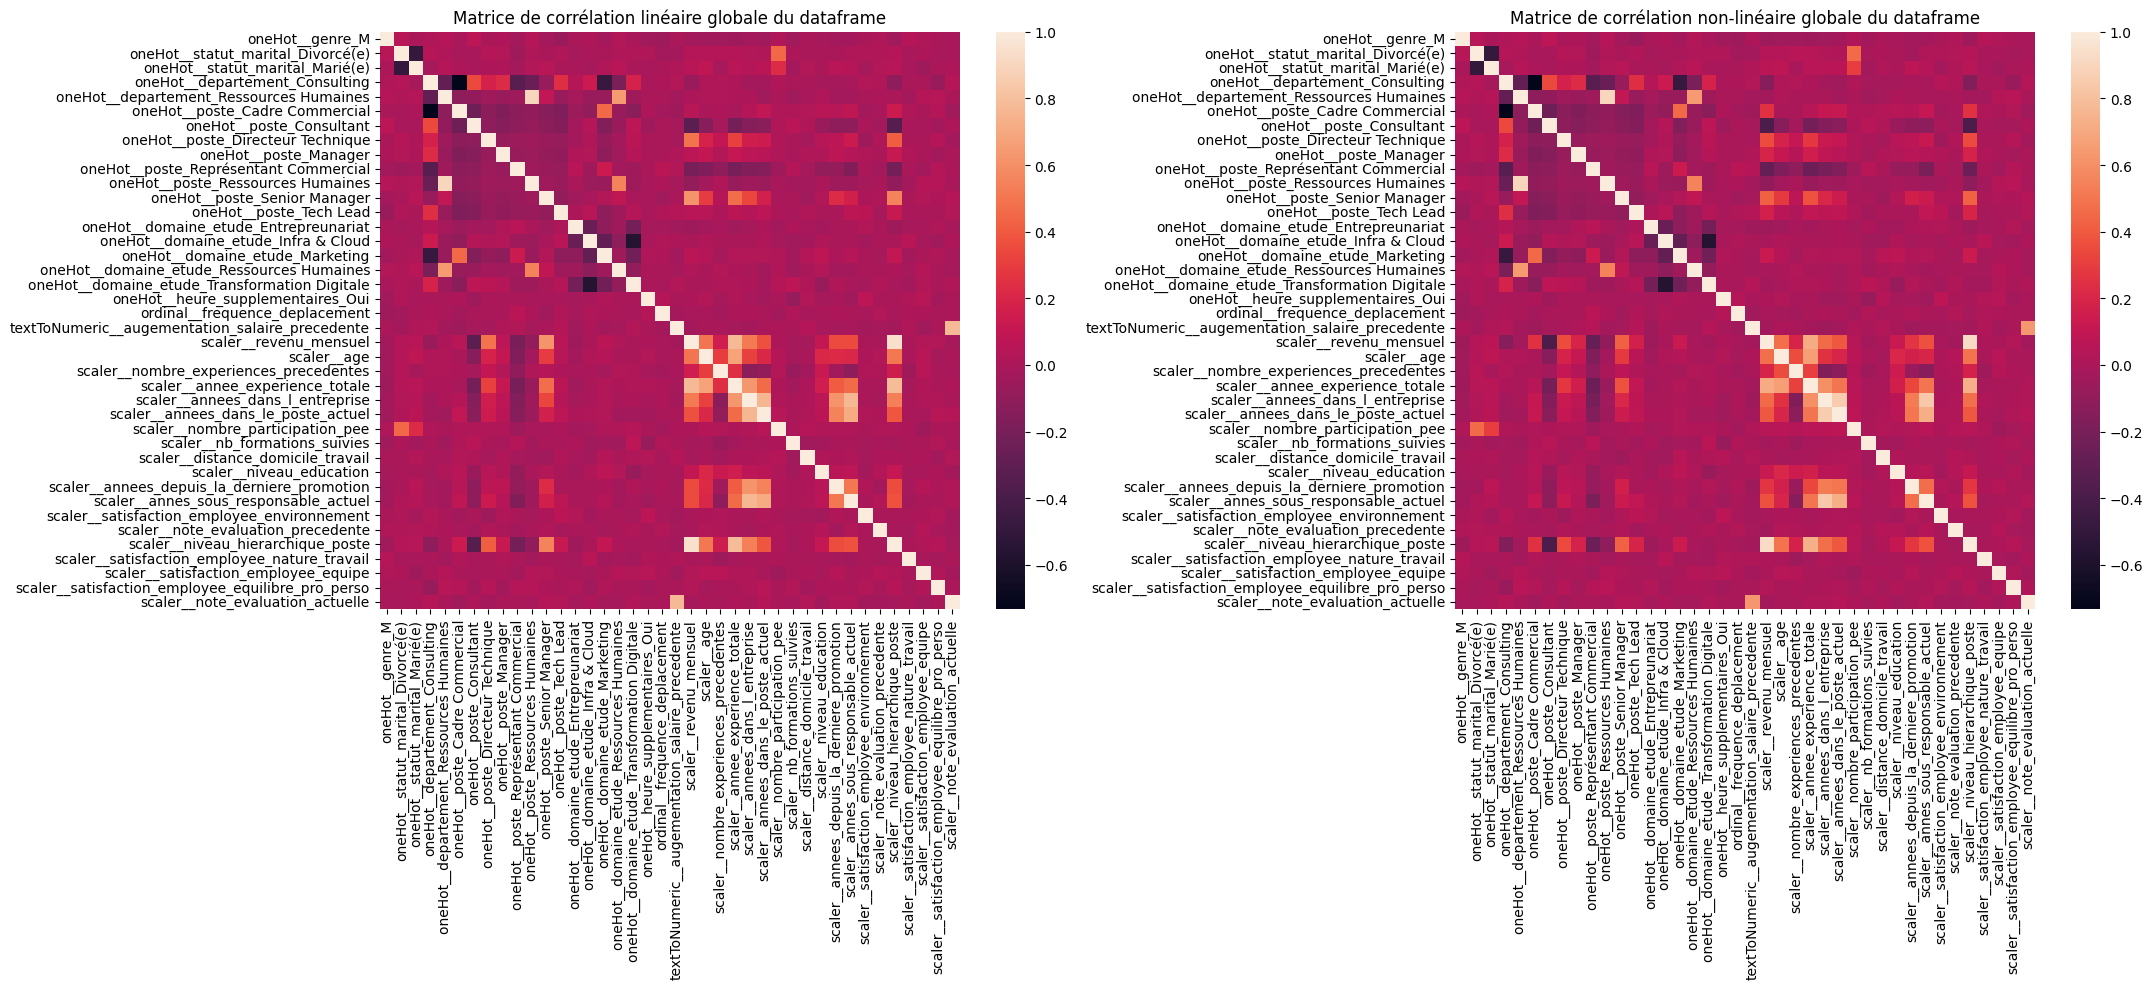

In [21]:
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

df_transformed = pd.DataFrame(X_transformed, columns=feature_names)

correlation_matrix = df_transformed.corr(method='pearson')
spearman_correlation_matrix = df_transformed.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(correlation_matrix, ax=axes[0])
axes[0].set_title("Matrice de corrélation linéaire globale du dataframe")

sns.heatmap(spearman_correlation_matrix, ax=axes[1])
axes[1].set_title("Matrice de corrélation non-linéaire globale du dataframe")
plt.tight_layout()

In [22]:
upper_linear_matrix_part = get_upper_matrix(correlation_matrix)
upper_non_linear_matrix_part = get_upper_matrix(spearman_correlation_matrix)

potential_dropped_linear_features = get_correlated(upper_linear_matrix_part)
potential_dropped_non_linear_features = get_correlated(upper_non_linear_matrix_part)

print(f"Nombre de colonnes avec une corrélation linéaire élevées: {len(potential_dropped_linear_features)}")
print(f"Nombre de colonnes avec une corrélation non linéaire élevées: {len(potential_dropped_non_linear_features)}")
print(f"Colonnes potentielles à drop:\n\tlinear:{potential_dropped_linear_features}\n\tnon linear {potential_dropped_non_linear_features}")

Nombre de colonnes avec une corrélation linéaire élevées: 2
Nombre de colonnes avec une corrélation non linéaire élevées: 2
Colonnes potentielles à drop:
	linear:['oneHot__poste_Ressources Humaines', 'scaler__niveau_hierarchique_poste']
	non linear ['oneHot__poste_Ressources Humaines', 'scaler__niveau_hierarchique_poste']


## Test des modèles avec un apprentissage non optimisé

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

pipelines = {}

for name, model in models.items():
    pipelines[name] = create_pipeline(
        preprocessor=preprocessor, model_name=name, model=model
    )

    pipelines[name].fit(X_train, y_train)

In [24]:
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    print(f"\n--- Rapport pour {name} ---")
    print(classification_report(y_test, y_pred))


--- Rapport pour Dummy ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294


--- Rapport pour Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.78      0.38      0.51        47

    accuracy                           0.88       294
   macro avg       0.84      0.68      0.72       294
weighted avg       0.88      0.88      0.87       294


--- Rapport pour Random Forest ---
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       247
           1       0.85      0.23      0.37        47

    accuracy                           0.87       294
   macro avg       0.8

c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

## Test des modèles avec les features redondantes en moins

In [25]:
pipelines_without_redundancy = {}

redundancy_selector = (
    "redundancy",
    FunctionTransformer(
        remove_redundancy,
        kw_args={"columns": potential_dropped_linear_features},
        validate=False,
    ),
)

for name, model in models.items():
    pipelines_without_redundancy[name] = create_pipeline(
        preprocessor=preprocessor,
        model=model,
        model_name=name,
        extra_steps=[redundancy_selector],
    )

    pipelines_without_redundancy[name].fit(X_train, y_train)

In [26]:
for name, pipeline in pipelines_without_redundancy.items():
    y_pred = pipeline.predict(X_test)
    print(f"\n--- Rapport pour {name} ---")
    print(classification_report(y_test, y_pred))


--- Rapport pour Dummy ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294


--- Rapport pour Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.78      0.38      0.51        47

    accuracy                           0.88       294
   macro avg       0.84      0.68      0.72       294
weighted avg       0.88      0.88      0.87       294


--- Rapport pour Random Forest ---
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       247
           1       0.88      0.15      0.25        47

    accuracy                           0.86       294
   macro avg       0.8

c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Aucune vraie différence

Text(0.5, 1.0, 'Matrice de confusion - Logistic Regression')

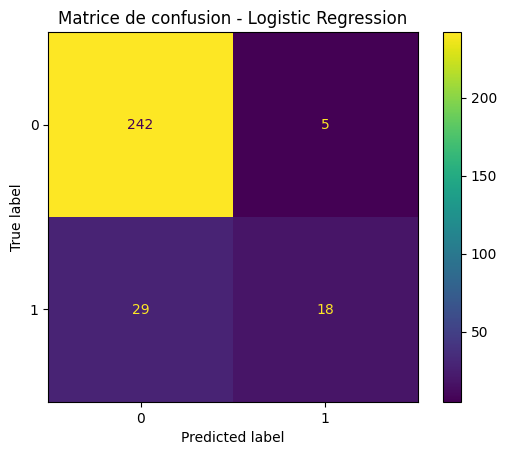

In [27]:
ConfusionMatrixDisplay.from_estimator(
    pipelines_without_redundancy["Logistic Regression"],
    X_test,
    y_test
)
plt.title("Matrice de confusion - Logistic Regression")

Text(0.5, 1.0, 'Matrice de confusion - Random Forest')

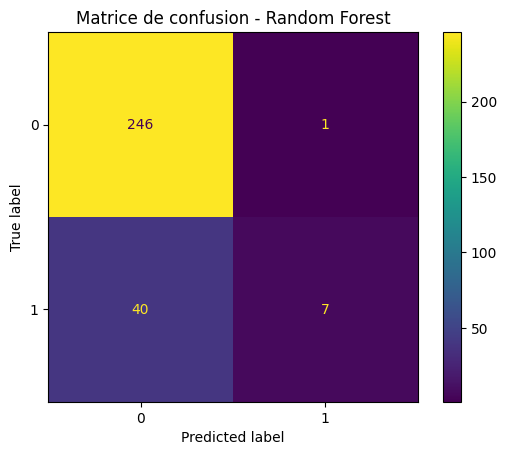

In [28]:
ConfusionMatrixDisplay.from_estimator(
    pipelines_without_redundancy["Random Forest"],
    X_test,
    y_test
)
plt.title("Matrice de confusion - Random Forest")

## Traitement du modèle linéaire

In [29]:
feature_selector = ("selector", SelectKBest())

pipeline_k_best = create_pipeline(
    preprocessor=preprocessor,
    model=LogisticRegression(max_iter=1000, class_weight="balanced"),
    model_name="K best logistic regression",
    extra_steps=[redundancy_selector, feature_selector],
)

pipeline_k_best.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
y_pred = pipeline_k_best.predict(X_test)
print("\n--- Rapport pour K best logistic regression ---")
print(classification_report(y_test, y_pred))


--- Rapport pour K best logistic regression ---
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       247
           1       0.31      0.70      0.43        47

    accuracy                           0.70       294
   macro avg       0.62      0.70      0.61       294
weighted avg       0.83      0.70      0.74       294



In [31]:
pipeline_grid = create_pipeline(
    preprocessor=preprocessor,
    model=LogisticRegression(class_weight="balanced", solver='liblinear', random_state=1234),
    model_name="logistic",
    extra_steps=[redundancy_selector, feature_selector],
)

grid_parameter = {
    'selector__k': ['all', 30, 25, 20, 15, 10, 5],
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2']
}

grid = GridSearchCV(
    pipeline_grid,
    grid_parameter,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleurs F1 scores en validation croisée: {grid.best_score_:.3f}")

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Meilleurs paramètres : {'logistic__C': 1, 'logistic__penalty': 'l1', 'selector__k': 'all'}
Meilleurs F1 scores en validation croisée: 0.497


## Traitement du modèle non linéaire

### Test avec des poids équilibrés

In [32]:
pipeline_rf = create_pipeline(
    preprocessor=preprocessor,
    model=RandomForestClassifier(class_weight='balanced', random_state=1234),
    model_name="rf",
    extra_steps=[redundancy_selector]
)

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
y_pred = pipeline_rf.predict(X_test)
print("\n--- Rapport pour random forest balanced ---")
print(classification_report(y_test, y_pred))


--- Rapport pour random forest balanced ---
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       247
           1       0.86      0.13      0.22        47

    accuracy                           0.86       294
   macro avg       0.86      0.56      0.57       294
weighted avg       0.86      0.86      0.81       294



### Test avec des poids supérieurs pour la target

In [34]:
pipeline_rf = create_pipeline(
    preprocessor=preprocessor,
    model=RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=1234),
    model_name="rf",
    extra_steps=[redundancy_selector]
)

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
y_pred = pipeline_rf.predict(X_test)
print("\n--- Rapport pour random forest weighted ---")
print(classification_report(y_test, y_pred))


--- Rapport pour random forest weighted ---
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       247
           1       0.78      0.15      0.25        47

    accuracy                           0.86       294
   macro avg       0.82      0.57      0.59       294
weighted avg       0.85      0.86      0.81       294



### Test en bridant le nombre d'arbres

In [36]:
pipeline_rf = create_pipeline(
    preprocessor=preprocessor,
    model=RandomForestClassifier(n_estimators=10, random_state=1234),
    model_name="rf",
    extra_steps=[redundancy_selector]
)

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred = pipeline_rf.predict(X_test)
print("\n--- Rapport pour random forest 10 arbres ---")
print(classification_report(y_test, y_pred))


--- Rapport pour random forest 10 arbres ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       247
           1       0.67      0.09      0.15        47

    accuracy                           0.85       294
   macro avg       0.76      0.54      0.53       294
weighted avg       0.82      0.85      0.79       294



### Test en bridant la profondeur des branches

In [38]:
pipeline_rf = create_pipeline(
    preprocessor=preprocessor,
    model=RandomForestClassifier(max_depth=10, random_state=1234),
    model_name="rf",
    extra_steps=[redundancy_selector]
)

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
y_pred = pipeline_rf.predict(X_test)
print("\n--- Rapport pour random forest branches 10 max ---")
print(classification_report(y_test, y_pred))


--- Rapport pour random forest branches 10 max ---
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       247
           1       0.80      0.17      0.28        47

    accuracy                           0.86       294
   macro avg       0.83      0.58      0.60       294
weighted avg       0.85      0.86      0.82       294



### Recherche des meilleurs combinaisons avec une Grid Search

In [40]:
pipeline_rf = create_pipeline(
    preprocessor=preprocessor,
    model=RandomForestClassifier(random_state=1234),
    model_name="rf",
    extra_steps=[redundancy_selector],
)

grid_parameters = {
    "rf__max_depth": [2, 5, 7, 10, 20],
    "rf__n_estimators": [10, 50, 100, 200],
    "rf__class_weight": [None, "balanced", {0: 1, 1: 10}],
    "rf__min_samples_leaf": [2, 5, 7, 10, 15],
    "rf__max_features": [None, 5, 10, 20, 30],
}

grid_rf = GridSearchCV(
    pipeline_rf, grid_parameters, cv=5, scoring="f1", verbose=True, n_jobs=-1
)
# Ne pas lancer ce bout de code, hormis pour perdre 5 minutes de votre vie (minimum j'ai une bonne machine)
# grid_rf.fit(X, y)

# print(f"Meilleurs paramètres : {grid_rf.best_params_}")
# print(f"Meilleurs F1 scores en validation croisée: {grid_rf.best_score_:.3f}")

Mauvaise direction, je vais changer mon preprocessor pour en faire un plus adapter à une random forest

### Preprocessor pour RF

In [41]:
rf_preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncoder, n-1 to avoid redundancy with drop first
        ("oneHot", OneHotEncoder(sparse_output=False), category_columns),
        # Managing all OrdinalEncoder
        (
            "ordinal",
            OrdinalEncoder(categories=ordinales_categories),
            ordinales_columns,
        ),
        # Special pipeline for text to numeric
        (
            "textToNumeric",
            FunctionTransformer(text_to_numeric, feature_names_out="one-to-one"),
            ["augementation_salaire_precedente"],
        ),
    ],
    remainder="passthrough",
)

In [42]:
pipeline_rf = create_pipeline(
    preprocessor=rf_preprocessor,
    model=RandomForestClassifier(random_state=1234, class_weight='balanced', min_samples_split=10),
    model_name="rf",
)

randomized_grid_parameters = {
    "rf__max_depth": [3, 5, 8],
    "rf__n_estimators": randint(50, 500),
    "rf__min_samples_leaf": randint(2, 20),
    "rf__max_features": ["sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=randomized_grid_parameters,
    n_iter=50,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=True
)

random_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {random_search.best_params_}")
print(f"Meilleurs F1 scores en validation croisée: {random_search.best_score_:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres : {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 16, 'rf__n_estimators': 274}
Meilleurs F1 scores en validation croisée: 0.501


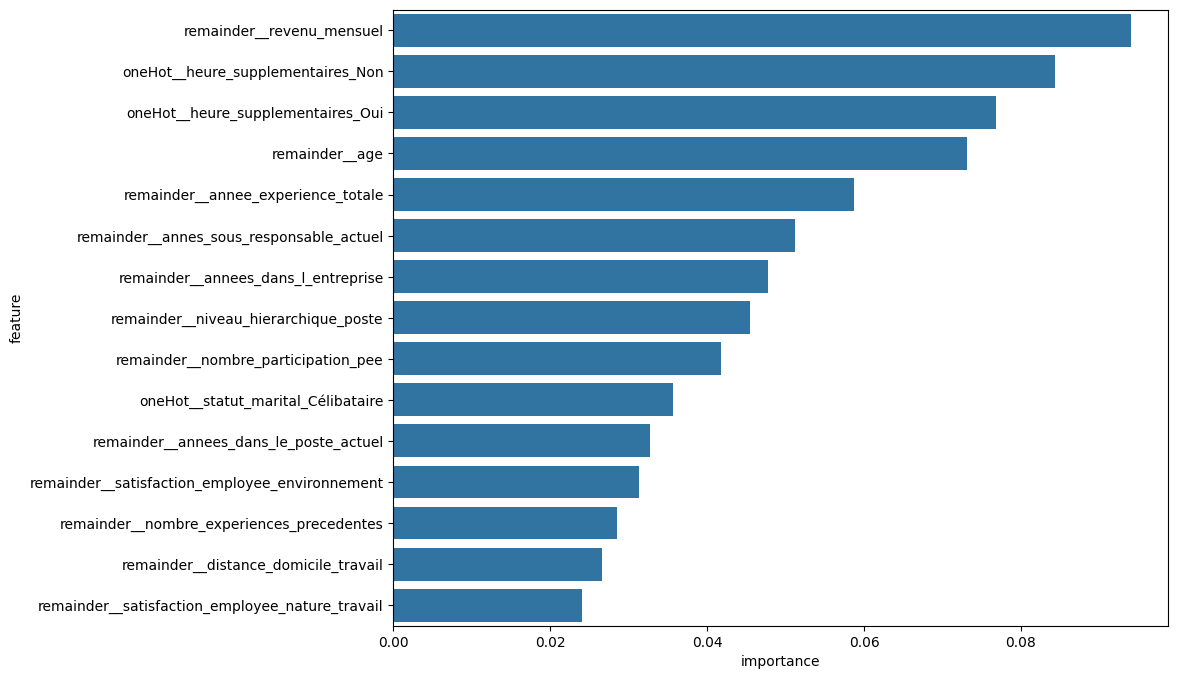

In [43]:
feature_names = random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
importances = random_search.best_estimator_.named_steps['rf'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.show()

### Création de features maison

In [44]:
X.head()

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,0,0,1,2,Infra & Cloud,Occasionnel,0,5,2,3,2,4,1,1,3,Oui,11 %
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,1,3,8,1,Infra & Cloud,Frequent,1,7,3,2,2,2,4,3,4,Non,23 %
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,0,3,2,2,Autre,Occasionnel,0,0,4,2,1,3,2,3,3,Oui,15 %
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,0,3,3,4,Infra & Cloud,Frequent,3,0,4,3,1,3,3,3,3,Oui,11 %
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,3,1,2,4,3,3,Non,12 %


In [45]:
def add_custom_features(X):
    X = X.copy()

    X['risque_burnout'] = X['distance_domicile_travail'] * X['heure_supplementaires'].apply(lambda x: 1 if x == 'Oui' else 0)
    X['volatilite'] = (10000 / (X['revenu_mensuel'] + 1)) * (X['statut_marital'].apply(lambda x:1 if x=="Célibataire" else 0.5)) * (1 / (X['annees_dans_l_entreprise'] + 1))
    X['stagnation'] = X['annees_dans_le_poste_actuel']  * X['annees_depuis_la_derniere_promotion']
    X['loyaute'] = (X['annees_dans_le_poste_actuel'] + 1) / (X['annes_sous_responsable_actuel'] + 1)

    return X

In [46]:
feature_engineering_step = ("engineering", FunctionTransformer(add_custom_features))

pipeline_rf_features = Pipeline([
    feature_engineering_step,
    ("preprocessor", rf_preprocessor),
    ("rf", RandomForestClassifier(random_state=1234, class_weight='balanced', min_samples_split=10))
])

random_search_tuned = RandomizedSearchCV(
    pipeline_rf_features,
    param_distributions=randomized_grid_parameters,
    n_iter=50,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=True
)

random_search_tuned.fit(X_train, y_train)

print(f"Meilleurs paramètres : {random_search_tuned.best_params_}")
print(f"Meilleurs F1 scores en validation croisée: {random_search_tuned.best_score_:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres : {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 12, 'rf__n_estimators': 53}
Meilleurs F1 scores en validation croisée: 0.504


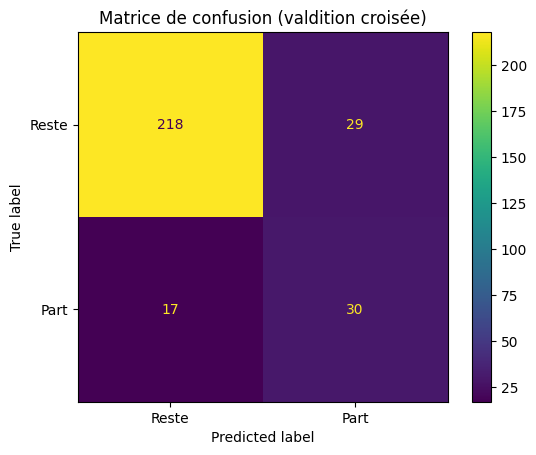

In [47]:
best_non_linear_model = random_search_tuned.best_estimator_
y_pred = best_non_linear_model.predict(X_test) 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Reste", "Part"])
plt.title("Matrice de confusion (valdition croisée)")
plt.show()

Text(0.5, 1.0, 'Courbe Précision/Rappel en fonction du seuil')

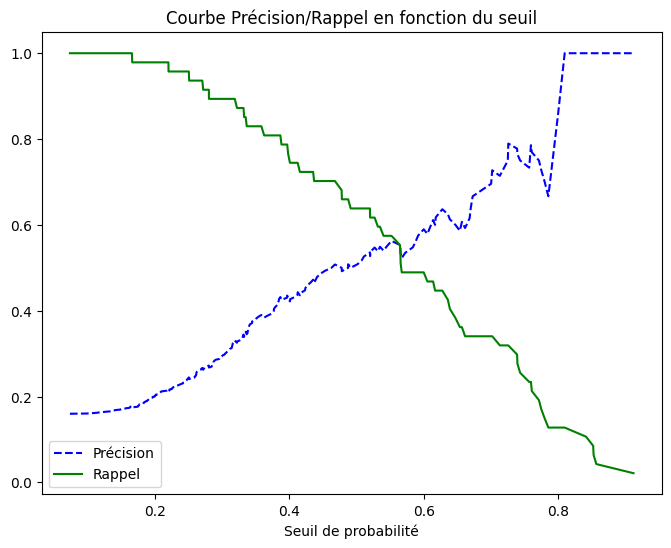

In [48]:
y_scores = best_non_linear_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[: -1], "b--", label="Précision")
plt.plot(thresholds, recalls[: -1], "g-", label="Rappel")
plt.xlabel("Seuil de probabilité")
plt.legend()
plt.title("Courbe Précision/Rappel en fonction du seuil")

On peut constater que le seuil optimal pour récupérer un maximum de vrais positifs se trouve au alentours de 0.35

In [49]:
best_threshold = 0.35

y_pred_custom = (y_scores >= best_threshold).astype(int)
print(f"Résultats avec seuil à {best_threshold} :")
print(classification_report(y_test, y_pred_custom))

Résultats avec seuil à 0.35 :
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       247
           1       0.38      0.83      0.52        47

    accuracy                           0.76       294
   macro avg       0.67      0.79      0.68       294
weighted avg       0.87      0.76      0.79       294



Text(0.5, 1.0, 'Matrice de confusion (Seuil optimisé : 0.35)')

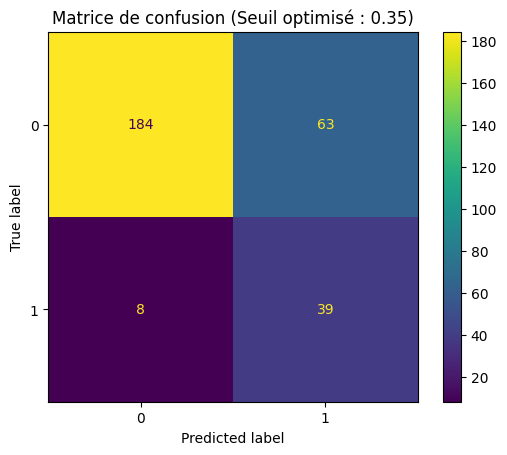

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom)
plt.title(f"Matrice de confusion (Seuil optimisé : {best_threshold})")

## Test avec le GradientBoosting

In [51]:
gbc_pipeline = Pipeline([
    feature_engineering_step,
    ("preprocessor", rf_preprocessor),
    ('gbc', GradientBoostingClassifier(random_state=1234))
])

random_parameters = {
    "gbc__learning_rate": [0.01, 0.1, 1, 10],
    "gbc__n_estimators": [50, 100, 200, 500],
    "gbc__min_samples_leaf": [2, 5, 7, 10, 15],
    "gbc__max_features": [None, 5, 10, 20, 30],
}


In [52]:
gbc_search = RandomizedSearchCV(
    gbc_pipeline,
    param_distributions=random_parameters,
    n_iter=50,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=True
)

gbc_search.fit(X_train, y_train)
print(f"Meilleurs paramètres: {gbc_search.best_params_}")
print(f"Meilleur score (F2): {gbc_search.best_score_:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres: {'gbc__n_estimators': 500, 'gbc__min_samples_leaf': 15, 'gbc__max_features': 20, 'gbc__learning_rate': 0.1}
Meilleur score (F2): 0.513


In [53]:
f2_scorer = make_scorer(fbeta_score, beta=2)

gbc_search_f2 = RandomizedSearchCV(
    gbc_pipeline,
    param_distributions=random_parameters,
    n_iter=50,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=True
)

gbc_search.fit(X_train, y_train)
print(f"Meilleurs paramètres: {gbc_search.best_params_}")
print(f"Meilleur score (F2): {gbc_search.best_score_:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres: {'gbc__n_estimators': 500, 'gbc__min_samples_leaf': 10, 'gbc__max_features': None, 'gbc__learning_rate': 1}
Meilleur score (F2): 0.513


Pas de réel gain

## Etude de l'importance des features

### Importance Native

In [54]:
model_final = best_non_linear_model.named_steps['rf']
features_name = random_search_tuned.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_test_transformed = best_non_linear_model.named_steps['preprocessor'].transform(add_custom_features(X_test))

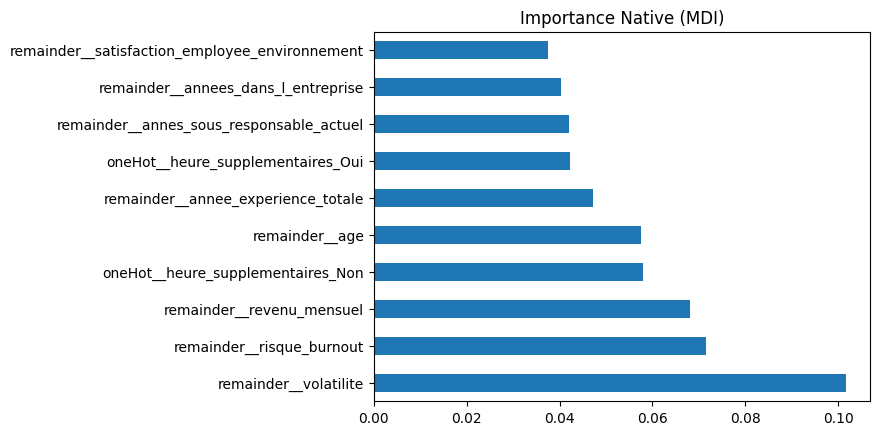

In [55]:
feature_importances = pd.Series(model_final.feature_importances_, index=features_name)
feature_importances.nlargest(10).plot(kind='barh', title="Importance Native (MDI)")
plt.show()

### Permutation Importance

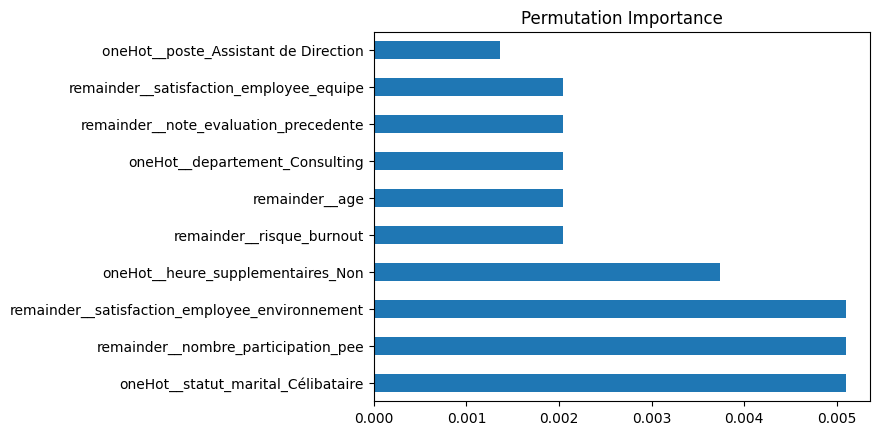

In [56]:
perm_importance = permutation_importance(model_final, X_test_transformed, y_test, n_repeats=10, random_state=1234)
pd.Series(perm_importance.importances_mean, index=features_name).nlargest(10).plot(kind="barh", title="Permutation Importance")
plt.show()

### BeeSwarm

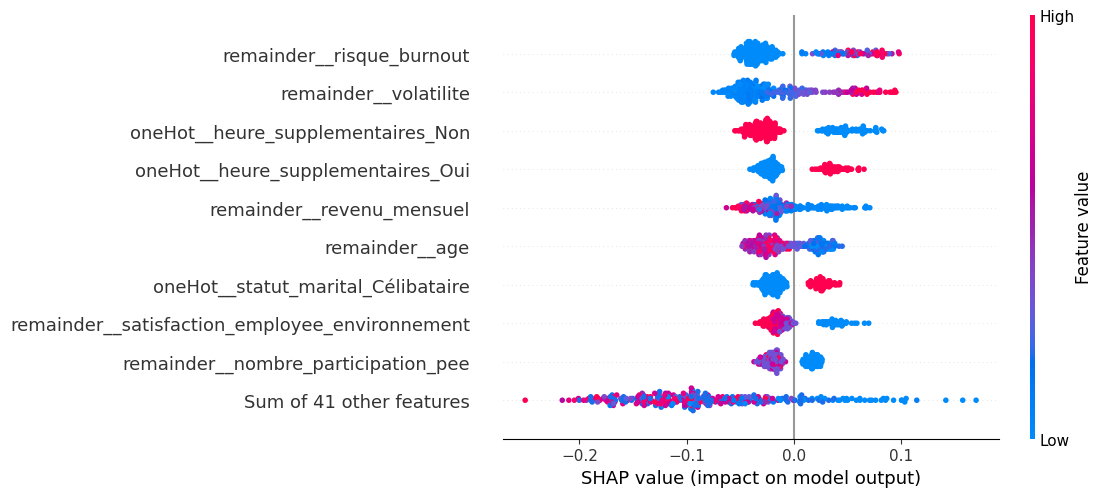

In [57]:
explainer = shap.TreeExplainer(model_final)
shap_local_values = explainer(X_test_transformed)
shap.plots.beeswarm(shap_local_values[:, :, 1])

### TreeExplainer

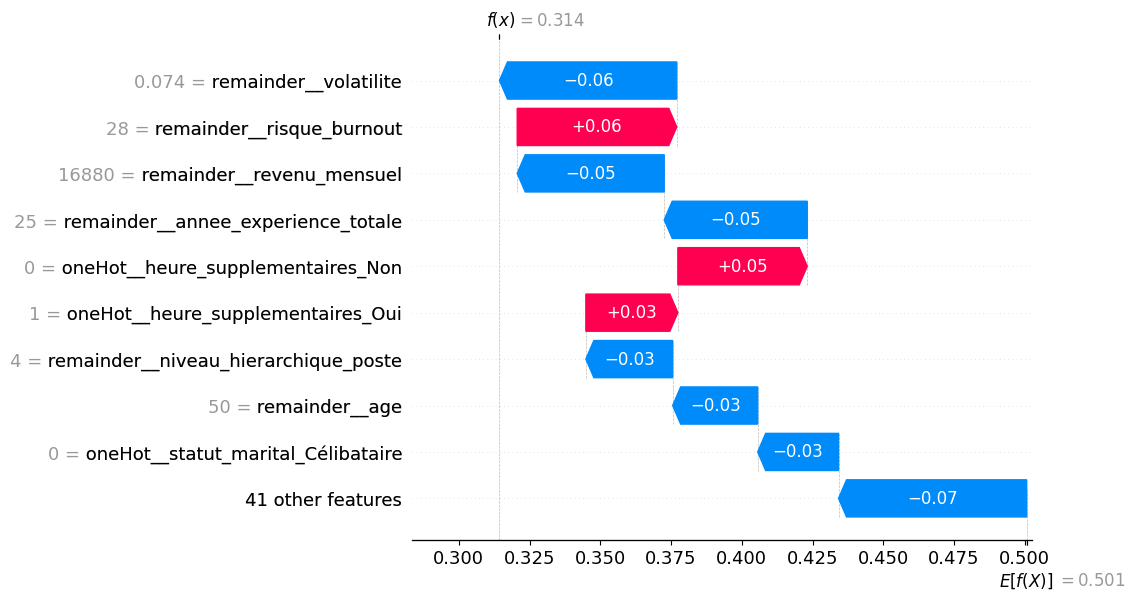

In [58]:
shap.plots.waterfall(shap_local_values[51, :, 1])

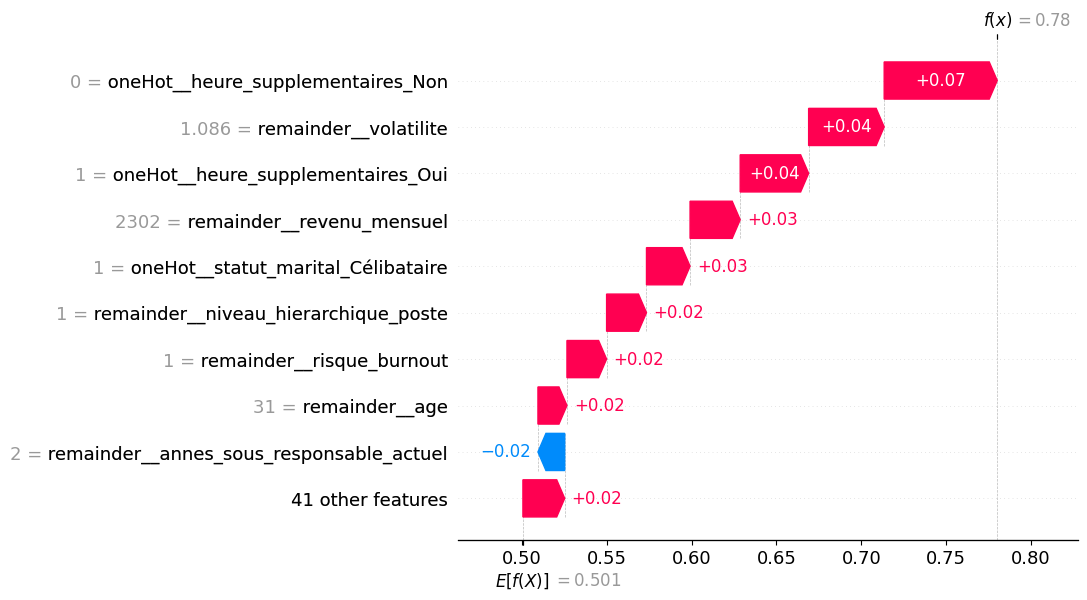

In [59]:
shap.plots.waterfall(shap_local_values[80, :, 1])

### Scatter

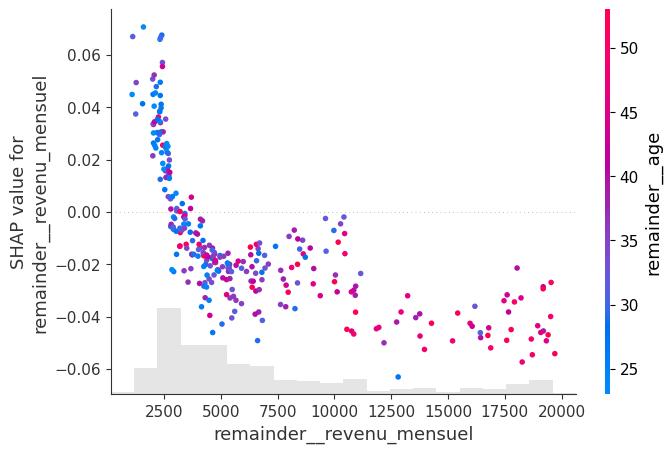

In [62]:
shap.plots.scatter(shap_local_values[:, 'remainder__revenu_mensuel', 1], color=shap_local_values[:, "remainder__age", 1])